# NBA Fantasy Points Prediction

In [371]:
import pandas as pd

player_logs_df = pd.read_csv('2023_nba_games_data')

# This is what the raw dataset looks like.
player_logs_df.head(5)

,G,Date,Age,Tm,At,Opp,Point_Dif,GS,MP,FG,...,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player,Pos
0,1,2022-10-19,23-030,TOR,NaN,CLE,W (+3),0,17.9,4,...,0,0,0,0,1,10,5.0,-4.0,achiupr01,C
1,2,2022-10-21,23-032,TOR,@,BKN,L (-4),0,17.5,1,...,0,0,0,3,2,4,-2.2,-8.0,achiupr01,C
2,3,2022-10-22,23-033,TOR,@,MIA,L (-3),0,33.5,5,...,1,0,0,1,1,18,17.1,16.0,achiupr01,C
3,4,2022-10-24,23-035,TOR,@,MIA,W (+8),0,33.7,5,...,2,0,1,0,2,10,12.7,10.0,achiupr01,C
4,5,2022-10-26,23-037,TOR,NaN,PHI,W (+10),0,21.3,3,...,4,0,0,2,3,7,5.9,14.0,achiupr01,C


# Convert Player Stats Into Fantasy Points And Derive the Game Number for the Player's team and the Opposing Team

In [372]:
# Use ESPN's standard scoring format for fantasy points to create the fan_pts column.
player_logs_df['Fan_Pts'] = (player_logs_df['PTS'] + player_logs_df['3P'] + player_logs_df['FG']*2 + player_logs_df['TRB'] + 
                            player_logs_df['AST']*2 + player_logs_df['STL']*4 + player_logs_df['BLK']*4 - 
                             player_logs_df['FGA'] - player_logs_df['TOV']*2)

# Get the player's team game number along with the opponent team's game number
player_logs_df['Date'] = pd.to_datetime(player_logs_df['Date'])
player_logs_df = player_logs_df.sort_values(['Tm', 'Date'])
player_logs_df = player_logs_df.sort_values(['Tm', 'Date'])
player_logs_df['Plr_Tm_Gm_Num'] = player_logs_df.groupby('Tm')['Date'].rank(method='dense').astype(int)
player_logs_df['Opp_Gm_Num'] = player_logs_df.groupby('Opp')['Date'].rank(method='dense').astype(int)

# Only keep the columns that wil be relevant (at least for now)
player_logs_df = player_logs_df[['GS','Player', 'Opp', 'Tm', 'MP', 'Fan_Pts', 'Pos', 'Plr_Tm_Gm_Num', 'Opp_Gm_Num']]

player_logs_df.head(5)

,GS,Player,Opp,Tm,MP,Fan_Pts,Pos,Plr_Tm_Gm_Num,Opp_Gm_Num
5395,1,capelca01,HOU,ATL,26.1,15,C,1,1
6130,1,collijo01,HOU,ATL,33.6,42,PF,1,1
13457,0,holidaa01,HOU,ATL,18.0,15,PG,1,1
13587,0,holidju01,HOU,ATL,18.5,16,SF,1,1
13588,0,holidju01,HOU,ATL,18.5,16,SF,1,1


# Prepare the data for our model

In [373]:
# Gets all the games a player was involved in.
games = player_logs_df.drop_duplicates(subset=['Tm', 'Plr_Tm_Gm_Num'], keep='first')

# Dummy dataframe that contains the fantasy points per minute an opposing team has conceded up to the game number.
df = pd.DataFrame({'PG': [], 'SG': [], 'SF': [], 'PF': [], 'C': [], 'Opp': [], 'Opp_Gm_Num': []})

# Iterates through all the games and calculates the fantasy points conceded per minute the opponent has surrendered up to their
# current game number.
for index, row in games.iterrows():
    team = row['Opp']
    opp_tm_num = row['Opp_Gm_Num']
    
    # A dataframe of all opponents and their games the opposing team has played so far
    opp_prev_opp_plrs = player_logs_df[((player_logs_df['Opp'] == team) & (player_logs_df['Opp_Gm_Num'] < opp_tm_num))]
    
    # Gets the fantasy points per minute e
    fan_pts_conceded_positions = opp_prev_opp_plrs.groupby('Pos').apply(lambda x: x['Fan_Pts'].sum() / x['MP'].sum())
    
    # If an opponent played a team that was missing a position, an NaN should be placed for that spot. It will be replaced
    # with the mean of the column.
    try:
        fan_pts_conceded_positions['PG']
    except:
        fan_pts_conceded_positions['PG'] = None
    try:
        fan_pts_conceded_positions['SG']
    except:
        fan_pts_conceded_positions['SG'] = None
    try:
        fan_pts_conceded_positions['SF']
    except:
        fan_pts_conceded_positions['SF'] = None
    try:
        fan_pts_conceded_positions['PF']
    except:
        fan_pts_conceded_positions['PF'] = None
    try:
        fan_pts_conceded_positions['C']
    except:
        fan_pts_conceded_positions['C'] = None

    df = df.append({'PG': fan_pts_conceded_positions['PG'], 'SG': fan_pts_conceded_positions['SG'],
                    'SF': fan_pts_conceded_positions['SF'], 'PF': fan_pts_conceded_positions['PF'],
                    'C': fan_pts_conceded_positions['C'], 'Opp': team, 'Opp_Gm_Num': int(opp_tm_num)}, ignore_index=True)
    
df[['PG', 'SG', 'SF', 'PF', 'C']] = df[['PG', 'SG', 'SF', 'PF', 'C']].apply(pd.to_numeric, errors='coerce')

df.head(5)

,PG,SG,SF,PF,C,Opp,Opp_Gm_Num
0,NaN,NaN,NaN,NaN,NaN,HOU,1.0
1,1.204819,1.293375,0.458919,0.791667,1.395833,ORL,2.0
2,0.887978,0.368601,1.223958,0.761079,1.200000,CHA,3.0
3,1.426621,1.212121,0.608656,0.789758,1.248706,DET,5.0
4,1.381188,1.203506,0.585009,0.846105,1.255924,DET,6.0


In [374]:
# Replace NaNs with the means of the column.
df['PG'] = df['PG'].fillna(df['PG'].mean())
df['SG'] = df['SG'].fillna(df['SG'].mean())
df['SF'] = df['SF'].fillna(df['SF'].mean())
df['PF'] = df['PF'].fillna(df['PF'].mean())
df['C'] = df['C'].fillna(df['C'].mean())

# Merge with the player dataframe so that we know the average fantasy points the opposing team has conceded up to that player's
# game.
player_logs_df = pd.merge(player_logs_df, df, on=['Opp', 'Opp_Gm_Num'], how='left')

player_logs_df.head(5)

,GS,Player,Opp,Tm,MP,Fan_Pts,Pos,Plr_Tm_Gm_Num,Opp_Gm_Num,PG,SG,SF,PF,C
0,1,capelca01,HOU,ATL,26.1,15,C,1,1,1.047716,0.871631,0.852195,0.955958,1.116272
1,1,collijo01,HOU,ATL,33.6,42,PF,1,1,1.047716,0.871631,0.852195,0.955958,1.116272
2,0,holidaa01,HOU,ATL,18.0,15,PG,1,1,1.047716,0.871631,0.852195,0.955958,1.116272
3,0,holidju01,HOU,ATL,18.5,16,SF,1,1,1.047716,0.871631,0.852195,0.955958,1.116272
4,0,holidju01,HOU,ATL,18.5,16,SF,1,1,1.047716,0.871631,0.852195,0.955958,1.116272


In [375]:
# Calculates the expected minutes a player will play by averaging the minutes the player played over the previous 2 games.
player_logs_df['Expected_Min'] = player_logs_df.groupby('Player')['MP'].apply(lambda x: x.shift().rolling(window=2, min_periods=1).mean())

# Replaces the NaNs with the mean of the column.
player_logs_df['Expected_Min'] = player_logs_df.groupby('Player')['Expected_Min'].apply(lambda x: x.fillna(x.mean()))

# Gets the average fantasy points conceded per minute by the opposing team to that player's position.
# This gives us a more accurate prediction. If a team is really good at defending centers, then if our player is a center,
# we would expect less fantasy points for them.
player_logs_df['Avg_Fan_Pts/Min_Opp_Conceded_To_Pos'] = player_logs_df.apply(lambda row: row[row['Pos']], axis=1)

# If a team as conceded 40 fantasy points per game to a center, it does not mean our player will be expected to get that much
# because our center may only play 10 minutes a game, which is why we should predict their fantasy points based on the expected
# minutes the player will play multipled by the conceded fantasy points per minute the opposing team has surrendered to that
# player's position so far.
player_logs_df['Expected_Conceded_Fan_Pts'] = player_logs_df['Expected_Min']*player_logs_df['Avg_Fan_Pts/Min_Opp_Conceded_To_Pos']

player_logs_df.head(5)

,GS,Player,Opp,Tm,MP,Fan_Pts,Pos,Plr_Tm_Gm_Num,Opp_Gm_Num,PG,SG,SF,PF,C,Expected_Min,Avg_Fan_Pts/Min_Opp_Conceded_To_Pos,Expected_Conceded_Fan_Pts
0,1,capelca01,HOU,ATL,26.1,15,C,1,1,1.047716,0.871631,0.852195,0.955958,1.116272,26.612500,1.116272,29.706794
1,1,collijo01,HOU,ATL,33.6,42,PF,1,1,1.047716,0.871631,0.852195,0.955958,1.116272,30.022857,0.955958,28.700600
2,0,holidaa01,HOU,ATL,18.0,15,PG,1,1,1.047716,0.871631,0.852195,0.955958,1.116272,13.235484,1.047716,13.867024
3,0,holidju01,HOU,ATL,18.5,16,SF,1,1,1.047716,0.871631,0.852195,0.955958,1.116272,15.267883,0.852195,13.011208
4,0,holidju01,HOU,ATL,18.5,16,SF,1,1,1.047716,0.871631,0.852195,0.955958,1.116272,18.500000,0.852195,15.765601


In [376]:
player_logs_df.sort_values(by=['Player', 'Plr_Tm_Gm_Num'], ascending=True, inplace=True)

player_logs_df['Plr_Tm_Gm_Num'] = player_logs_df['Plr_Tm_Gm_Num'].astype(int)

# Set 'Player' as the index for the DataFrame
player_logs_df.set_index('Player', inplace=True)

# Group the DataFrame by 'Player' and apply the rolling average on 'Fan_Pts' column to get the average fantasy points
# a player has scored over the previous 20 games (or 19, 18 and so on if less than 20 games have been played)
player_logs_df['Prev_20_Gm_Avg_Fan_Pts'] = player_logs_df.groupby('Player')['Fan_Pts'].apply(lambda x: x.shift().rolling(window=20, min_periods=1).mean())

# Replace the NaNs with the column average.
player_logs_df['Prev_20_Gm_Avg_Fan_Pts'] = player_logs_df.groupby('Player')['Prev_20_Gm_Avg_Fan_Pts'].apply(lambda x: x.fillna(x.mean()))

# Reset the index of the DataFrame if needed
player_logs_df.reset_index(inplace=True)

player_logs_df.head(5)

,Player,GS,Opp,Tm,MP,Fan_Pts,Pos,Plr_Tm_Gm_Num,Opp_Gm_Num,PG,SG,SF,PF,C,Expected_Min,Avg_Fan_Pts/Min_Opp_Conceded_To_Pos,Expected_Conceded_Fan_Pts,Prev_20_Gm_Avg_Fan_Pts
0,achiupr01,0,CLE,TOR,17.9,13,C,1,1,1.047716,0.871631,0.852195,0.955958,1.116272,20.537037,1.116272,22.924924,19.379063
1,achiupr01,0,BKN,TOR,17.5,0,C,2,2,0.312989,1.543408,1.393324,1.204819,1.229167,17.900000,1.229167,22.002083,13.000000
2,achiupr01,0,MIA,TOR,33.5,32,C,3,3,0.762301,0.992991,1.542361,0.691589,0.916667,17.700000,0.916667,16.225000,6.500000
3,achiupr01,0,MIA,TOR,33.7,38,C,4,4,0.816844,0.995984,1.381128,0.977948,0.867419,25.500000,0.867419,22.119182,15.000000
4,achiupr01,0,PHI,TOR,21.3,17,C,5,5,0.755518,0.754639,1.058956,1.006753,0.965211,33.600000,0.965211,32.431105,20.750000


In [377]:
# Gets the columns that have been prepped for our machine learning model.
player_logs = player_logs_df[['Prev_20_Gm_Avg_Fan_Pts', 'Expected_Conceded_Fan_Pts', 'Fan_Pts', 'Avg_Fan_Pts/Min_Opp_Conceded_To_Pos']]

# Just to guarantee that are never any NaNs.
player_logs.dropna(inplace=True)

player_logs.head(5)

C:\Users\sfedd\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Prev_20_Gm_Avg_Fan_Pts,Expected_Conceded_Fan_Pts,Fan_Pts,Avg_Fan_Pts/Min_Opp_Conceded_To_Pos
0,19.379063,22.924924,13,1.116272
1,13.000000,22.002083,0,1.229167
2,6.500000,16.225000,32,0.916667
3,15.000000,22.119182,38,0.867419
4,20.750000,32.431105,17,0.965211


# Plot the variables

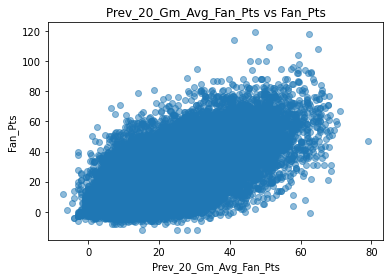

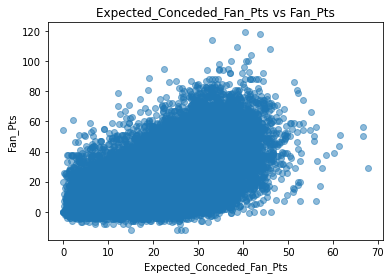

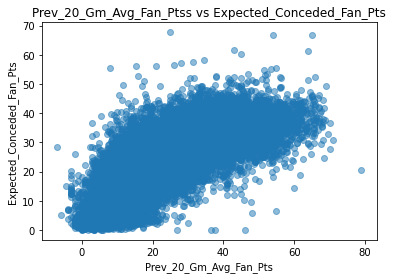

In [382]:
import matplotlib.pyplot as plt

# Create the first scatter plot with translucent points
plt.scatter(player_logs['Prev_20_Gm_Avg_Fan_Pts'], player_logs['Fan_Pts'], alpha=0.5)
plt.xlabel('Prev_20_Gm_Avg_Fan_Pts')
plt.ylabel('Fan_Pts')
plt.title('Prev_20_Gm_Avg_Fan_Pts vs Fan_Pts')
plt.show()

# Create the second scatter plot with translucent points
plt.scatter(player_logs['Expected_Conceded_Fan_Pts'], player_logs['Fan_Pts'], alpha=0.5)
plt.xlabel('Expected_Conceded_Fan_Pts')
plt.ylabel('Fan_Pts')
plt.title('Expected_Conceded_Fan_Pts vs Fan_Pts')
plt.show()

# We need to make sure that our independent variables are not dependent on each other.
plt.scatter(player_logs['Prev_20_Gm_Avg_Fan_Pts'], player_logs['Expected_Conceded_Fan_Pts'], alpha=0.5)
plt.xlabel('Prev_20_Gm_Avg_Fan_Pts')
plt.ylabel('Expected_Conceded_Fan_Pts')
plt.title('Prev_20_Gm_Avg_Fan_Ptss vs Expected_Conceded_Fan_Pts')
plt.show()

In [379]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Linear regression for Prev_5_Gm_Avg_Fan_Pts vs Fan_Pts
X1 = player_logs[['Prev_20_Gm_Avg_Fan_Pts']]
y1 = player_logs['Fan_Pts']
model1 = LinearRegression()
model1.fit(X1, y1)
r2_1 = r2_score(y1, model1.predict(X1))

# Linear regression for Expected_Conceded_Fan_Pts vs Fan_Pts
X2 = player_logs[['Expected_Conceded_Fan_Pts']]
y2 = player_logs['Fan_Pts']
model2 = LinearRegression()
model2.fit(X2, y2)
r2_2 = r2_score(y2, model2.predict(X2))

# Linear regression for Expected_Conceded_Fan_Pts vs Fan_Pts.
# We need to make sure our independent variables are not dependent on eachother.
X2 = player_logs[['Expected_Conceded_Fan_Pts']]
y2 = player_logs['Prev_20_Gm_Avg_Fan_Pts']
model2 = LinearRegression()
model2.fit(X2, y2)
r2_3 = r2_score(y2, model2.predict(X2))

# Printing R^2 values
# It seems our independent variables depend on eachother fairly significantly.
# Because Expected_Conceded_Fan_Pts uses expected minutes, and Prev_20_Gm_Avg_Fan_Pts is significantly impacted by expected
# minutes, we may need to try another variable. Because we have a good R^2 for Prev_20_Gm_Avg_Fan_Pts, we should keep it.
print("R^2 for Prev_20_Gm_Avg_Fan_Pts vs Fan_Pts:", r2_1)
print("R^2 for Expected_Conceded_Fan_Pts vs Fan_Pts:", r2_2)
print("R^2 for Prev_20_Gm_Avg_Fan_Pts vs Expected_Conceded_Fan_Pts:", r2_3)

R^2 for Prev_20_Gm_Avg_Fan_Pts vs Fan_Pts: 0.4519427136144071
R^2 for Expected_Conceded_Fan_Pts vs Fan_Pts: 0.3779554203298884
R^2 for Prev_20_Gm_Avg_Fan_Pts vs Expected_Conceded_Fan_Pts: 0.6053611568200663


Run The Linear Regression Machine Learning Model

In [380]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define the features and target
X = player_logs[['Expected_Conceded_Fan_Pts', 'Prev_20_Gm_Avg_Fan_Pts']]
y = player_logs['Fan_Pts']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score: ", r2)

R^2 Score:  0.48001172667406433


R^2 values can be deceptive, so we must plot our residuals to see if there is a pattern in our residuals.

C:\Users\sfedd\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


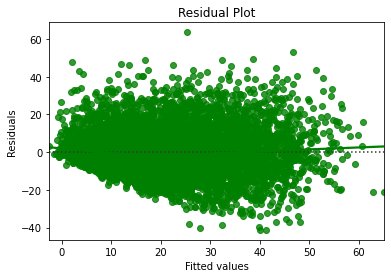

In [381]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
sns.residplot(y_pred, residuals, lowess=True, color="g")
plt.title('Residual Plot')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()